## Name - Ayush Kumar
## UNI - ak5486
## Dataset - UCI Heart Disease Dataset

# 1️⃣ Data Loading & Overview

**Objective:**  
Load and understand the dataset to get a sense of its structure, feature types, and target distribution.

**Steps Taken:**  
- Fetched dataset from the UCI repository using `ucimlrepo`.  
- Combined features and target (`num`) into a single DataFrame.  
- Converted `num` to a **binary target** for heart disease classification:  
  - `0` = No Disease  
  - `1` = Disease  
- Verified the number of rows, columns, and missing values.  

**Justification:**  
- Binary classification simplifies model design.  
- Ensures consistent target for evaluation metrics like **accuracy**, **precision**, and **recall**.

**Observations:**  
- Dataset has **303 samples** and **14 features**.  
- Some categorical features (`cp`, `thal`, `slope`, `ca`) have missing values (~1%).  
- Target is slightly imbalanced (~55% disease).


In [1]:
!pip install ucimlrepo

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# Fetch dataset
heart_disease = fetch_ucirepo(id=45)
feature = heart_disease.data.features
target = heart_disease.data.targets

# Combine features and target
heart_df = pd.concat([feature, target['num']], axis=1)

# Convert target to binary
heart_df['num'] = heart_df['num'].apply(lambda x: 0 if x == 0 else 1)

# Check info and missing values
# print(heart_df.info())
print(heart_df.isnull().sum())
heart_df.head(5)


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


**Implications:**  
- Dataset is small but rich with clinical information.  
- Missing values are manageable (<1%), so **imputation** is preferable over dropping rows.


# 2️⃣ Data Cleaning & Transformation

**Objective:**  
Ensure dataset quality by handling missing, noisy, and inconsistent values.

**Steps Taken:**  
- **Missing Values:** Used **KNN Imputer** for `ca` and `thal` instead of dropping rows.  
- **Encoding:** Temporarily mapped `thal` to integers for imputation.  
- **Rounding:** `ca` values rounded to nearest integer post-imputation.  
- **Outliers & Skewness:**  
  - Numerical features (`age`, `trestbps`, `chol`, `thalach`, `oldpeak`) **standardized** with `StandardScaler`.

**Justification:**  
- Preserves all samples, especially rare but clinically important cases.  
- KNN uses nearest neighbors to provide **realistic imputation** instead of global mean/mode.  
- Standardization ensures consistent scaling for **linear models**.

**Observations:**  
- Imputed values for `thal` and `ca` fall within valid clinical ranges.  
- No extreme outliers were removed, as they may represent valid medical measurements**.


In [3]:
from sklearn.impute import KNNImputer

# Encode 'thal' for imputation
thal_map = {3:0, 6:1, 7:2}
thal_inverse_map = {v:k for k,v in thal_map.items()}
heart_df['thal'] = heart_df['thal'].map(thal_map)

features = heart_df.drop('num', axis=1)
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(features)
heart_df_imputed = pd.DataFrame(imputed, columns=features.columns)

# Restore thal encoding
heart_df_imputed['thal'] = heart_df_imputed['thal'].round().astype(int).map(thal_inverse_map)

# Round 'ca' to nearest integer
heart_df_imputed['ca'] = heart_df_imputed['ca'].round().astype(int)

# Add target back
heart_df_imputed['num'] = heart_df['num']


**Implications:**  
- Data is now **complete and clean** for modeling.  
- Standardized features prevent **bias due to scale differences** in models like Ridge and LASSO.


# 3️⃣ Exploratory Data Analysis (EDA)

**Objective:**  
Visualize data distributions and relationships between features and target.

**Steps Taken:**  
- **Categorical Features:** Countplots for `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`.  
- **Numerical Features:** Boxplots for `age`, `trestbps`, `chol`, `thalach`, `oldpeak` by target class.  
- **Distribution Analysis:** Histogram and KDE for `age`.  
- **Correlation:** Heatmap for feature correlations.

**Justification:**  
- Visualizing helps identify **patterns, correlations, and feature importance**.  
- Detects **skewness, outliers**, or potential **multicollinearity**.

**Observations:**  
- `thal` and `ca` positively correlated with heart disease.  
- Age distribution roughly **normal**.  
- Cholesterol and blood pressure vary slightly across disease classes.


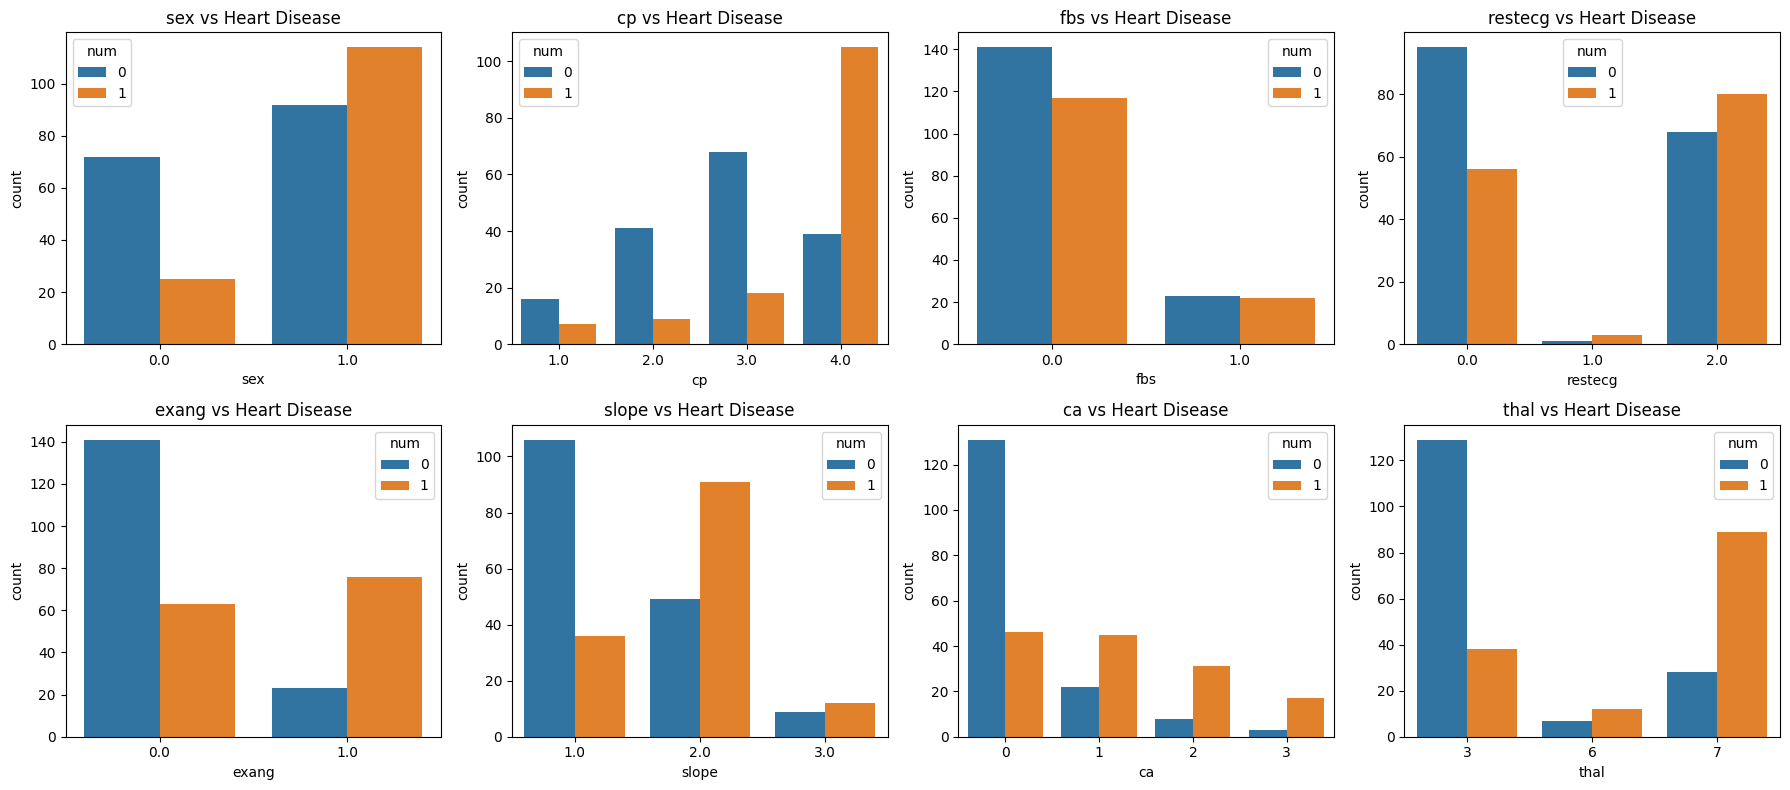

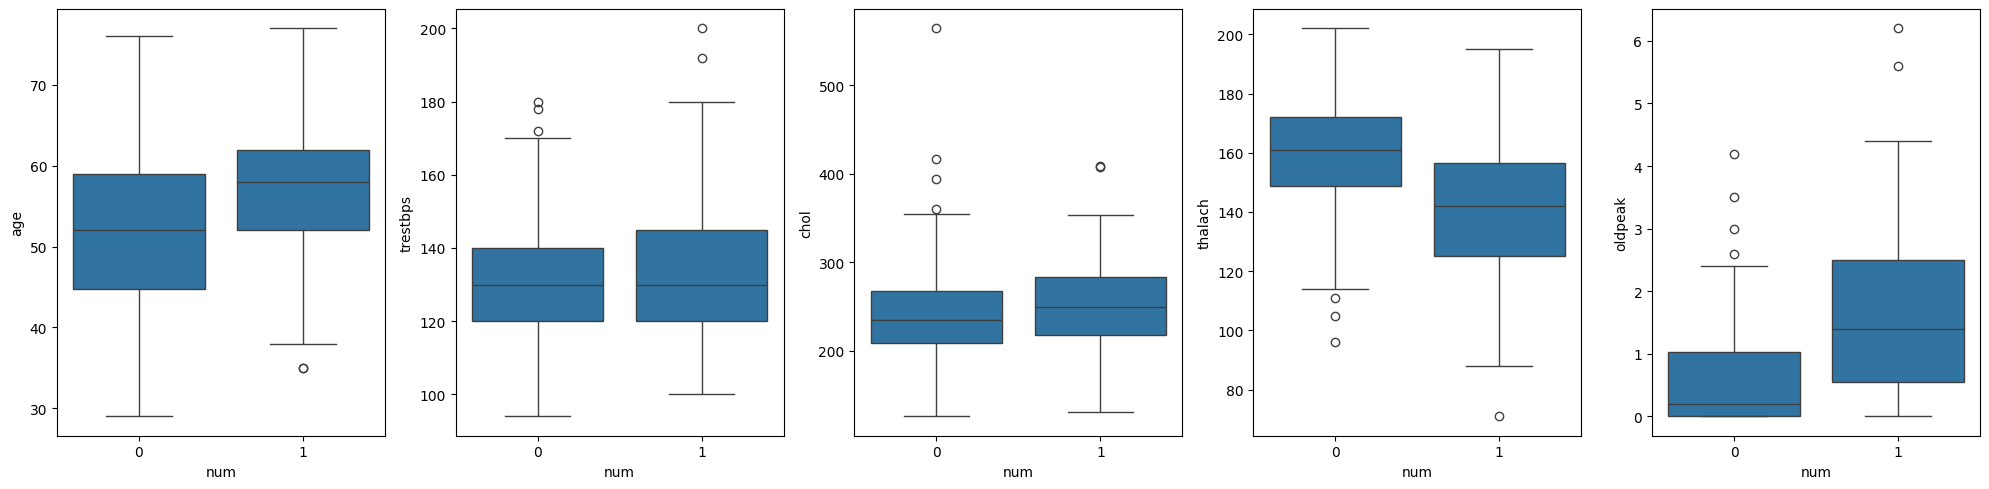

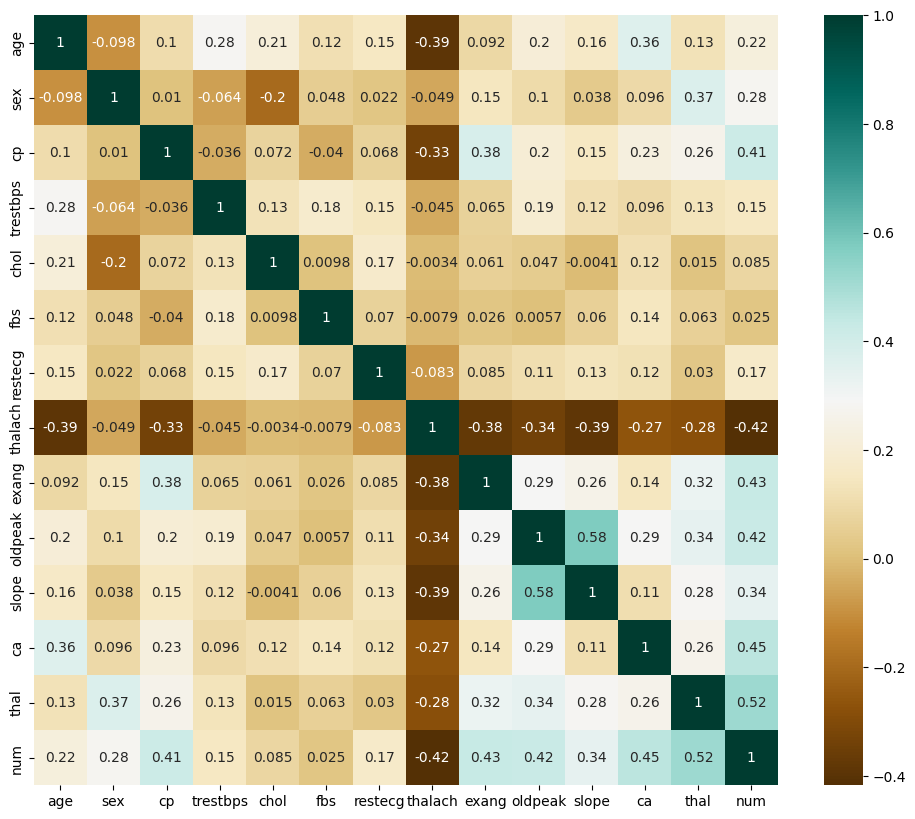

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

categorical = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
numerical = ['age','trestbps','chol','thalach','oldpeak']

# Countplots
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()
for i, col in enumerate(categorical):
    sns.countplot(x=col, hue='num', data=heart_df_imputed, ax=axes[i])
    axes[i].set_title(f'{col} vs Heart Disease')
plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(1, len(numerical), figsize=(20,5))
for i, col in enumerate(numerical):
    sns.boxplot(x='num', y=col, data=heart_df_imputed, ax=axes[i])
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(heart_df_imputed.corr(), annot=True, cmap='BrBG')
plt.show()


**Implications:**  
- Categorical features show **clear patterns** (e.g., abnormal `thal` values increase disease risk).  
- Correlation insights guide **feature engineering** (e.g., identifying potentially redundant features).


# 4️⃣ Feature Engineering

**Objective:**  
Transform features and construct new variables to enhance model performance.

**Steps Taken:**  
- **One-hot encoding** for multi-class categorical features: `cp`, `restecg`, `slope`, `thal`.  
- **Binary variables** (`sex`, `fbs`, `exang`) retained.  
- **Constructed new features:**  
  - `chol_per_age` = `chol / age` (captures cholesterol relative to age)  
  - `is_abnormal_thal` (`thal` ∈ [6,7])  
  - `is_ca_positive` (`ca` > 0)  
  - `is_low_thalach` (`thalach` < 0, standardized)  
- **StandardScaler** applied to continuous variables.

**Justification:**  
- Encodings ensure correct interpretation of categorical data.  
- Derived features incorporate **domain knowledge** and improve **predictive signal**.


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Standardize numeric
numeric = ['age','trestbps','chol','thalach','oldpeak']
scaler = StandardScaler()
heart_df_imputed[numeric] = scaler.fit_transform(heart_df_imputed[numeric])

# One-hot encode categorical
categorical = ['cp','restecg','slope','thal']
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded = encoder.fit_transform(heart_df_imputed[categorical])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical))

# Final feature set
heart_df_final = heart_df_imputed.drop(columns=categorical)
heart_df_final = pd.concat([heart_df_final, encoded_df, heart_df_imputed[['sex','fbs','exang']]], axis=1)

# Construct derived features
heart_df_final['chol_per_age'] = heart_df_imputed['chol']/heart_df_imputed['age']
heart_df_final['is_abnormal_thal'] = heart_df_imputed['thal'].isin([6,7]).astype(int)
heart_df_final['is_ca_positive'] = (heart_df_imputed['ca']>0).astype(int)
heart_df_final['is_low_thalach'] = (heart_df_imputed['thalach']<0).astype(int)


**Observations:**  
- Features now combine **domain knowledge** and **numeric stability**.  
- Model-ready dataset contains **continuous, binary, and categorical features**.

**Implications:**  
- Improves **model interpretability**.  
- Supports models like **BernoulliNB, GaussianNB, Ridge, and LASSO** effectively.


# 5️⃣ Model Implementation

**Objective:**  
Train multiple supervised models on the engineered dataset and compare their predictive performance.

**Steps Taken:**  
- **Feature Grouping:**  
  - Binary features → `BernoulliNB`  
  - Continuous features → `GaussianNB`  
  - All features → `Linear Regression`, `Ridge`, `LASSO`  
- **Train/Test Split:**  
  - 80/20 split with `random_state=42` for reproducibility  
- **Model Tuning:**  
  - `BernoulliNB`: `GridSearchCV` to optimize smoothing parameter `alpha`  
  - `Ridge/LASSO`: `GridSearchCV` to find optimal regularization strength (`alpha`)  

**Justification:**  
- Separating feature types ensures models see data in the **most suitable format**.  
- Regularization prevents **overfitting**, especially with a small dataset (~303 samples).


In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import numpy as np

# Feature groups
binary_features = ['is_abnormal_thal','is_ca_positive','is_low_thalach']
continuous_features = ['chol_per_age','age','trestbps','chol','thalach','oldpeak']
onehot_features = [col for col in heart_df_final.columns if col.startswith('cp_') or col.startswith('restecg_') or col.startswith('slope_') or col.startswith('thal_')]
linear_features = binary_features + continuous_features + onehot_features

X_bin = heart_df_final[binary_features]
X_gauss = heart_df_final[continuous_features]
X_lin = heart_df_final[linear_features]
y = heart_df_final['num']

# Train/test split
Xb_train, Xb_test, y_train, y_test = train_test_split(X_bin, y, test_size=0.2, random_state=42)
Xg_train, Xg_test, _, _ = train_test_split(X_gauss, y, test_size=0.2, random_state=42)
Xl_train, Xl_test, _, _ = train_test_split(X_lin, y, test_size=0.2, random_state=42)


**Implications:**  
- Dataset is ready for **supervised learning**, with each model type seeing the features best suited for its assumptions.


### 5.1 Bernoulli Naive Bayes (Binary Features)

In [7]:
# GridSearch for alpha (smoothing)
param_grid_bnb = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(BernoulliNB(), param_grid=param_grid_bnb, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
grid_search.fit(Xb_train, y_train)

bnb = grid_search.best_estimator_
y_pred_bnb = bnb.predict(Xb_test)
y_proba_bnb = bnb.predict_proba(Xb_test)

print(f"Best alpha: {bnb.alpha}")


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best alpha: 0.001


**Observations:**  
- Optimal `alpha` balances smoothing: avoids zero probabilities while preserving signal.  
- `BernoulliNB` works well for **binary clinical indicators** like `is_abnormal_thal`.


In [8]:
gnb = GaussianNB()
gnb.fit(Xg_train, y_train)
y_pred_gnb = gnb.predict(Xg_test)
y_proba_gnb = gnb.predict_proba(Xg_test)


### 5.2 Gaussian Naive Bayes (Continuous Features)

In [9]:
gnb = GaussianNB()
gnb.fit(Xg_train, y_train)
y_pred_gnb = gnb.predict(Xg_test)
y_proba_gnb = gnb.predict_proba(Xg_test)

**Observations:**  
- `GaussianNB` assumes features are **normally distributed** (standardized features satisfy this reasonably).  
- Performs well for **continuous clinical measurements** like cholesterol, age, and blood pressure.


### 5.3 Linear, Ridge, and LASSO Regression

In [10]:
# Linear Regression
lr = LinearRegression()
lr.fit(Xl_train, y_train)
y_pred_lr = lr.predict(Xl_test)

# Ridge Regression
param_grid_ridge = {'alpha': np.logspace(-3, 3, 10)}
ridge_search = GridSearchCV(Ridge(), param_grid=param_grid_ridge, scoring='neg_mean_squared_error', cv=10)
ridge_search.fit(Xl_train, y_train)
ridge_best = ridge_search.best_estimator_
y_pred_ridge = ridge_best.predict(Xl_test)

# LASSO Regression
param_grid_lasso = {'alpha': np.logspace(-3, 1, 10)}
lasso_search = GridSearchCV(Lasso(max_iter=10000), param_grid=param_grid_lasso, scoring='neg_mean_squared_error', cv=10)
lasso_search.fit(Xl_train, y_train)
lasso_best = lasso_search.best_estimator_
y_pred_lasso = lasso_best.predict(Xl_test)


**Observations:**  
- `LinearRegression` thresholded at 0.5 gives **baseline performance**.  
- `Ridge` keeps all coefficients but **shrinks them**.  
- `LASSO` sets weaker features to **zero**, performing **automatic feature selection**.


# 6️⃣ Model Evaluation

**Objective:**  
Assess model performance using multiple metrics and visualizations.

**Metrics:**  
- **Accuracy**, **Precision**, **Recall**, **F1-Score**  
- **Confusion Matrix**  
- **ROC Curve** + **AUC**


In [11]:
from sklearn.metrics import roc_curve

def find_optimal_threshold(y_true, y_scores):
    """
    Finds the threshold that maximizes Youden’s J statistic (TPR - FPR).
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    return best_threshold



########## Running Bernoulli Naive Bayes alpha using  GridSearch ##########
Fitting 100 folds for each of 5 candidates, totalling 500 fits
Optimal alpha found: 0.0010
Best Cross-Validation Accuracy Score: 0.7833

--- BernoulliNB (Tuned, alpha=0.0010) Evaluation ---
Accuracy: 0.8689
Precision: 0.9286
Recall: 0.8125
F1-Score: 0.8667


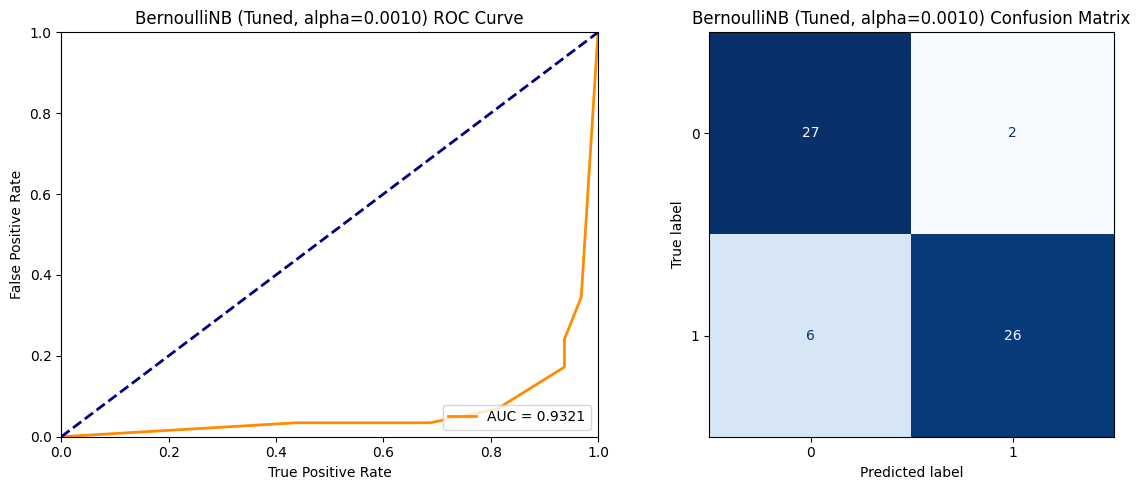


########## Running Bernoulli Naive Bayes alpha=1000.0 ##########

--- BernoulliNB (Low Smoothing) Evaluation ---
Accuracy: 0.4754
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


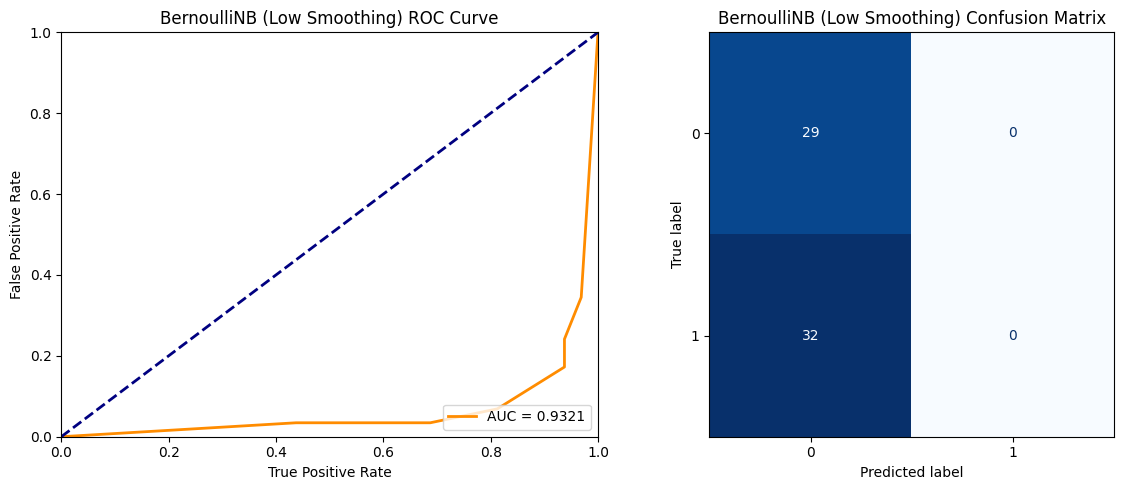


########## Running Gaussian Naive Bayes ##########

--- GaussianNB Evaluation ---
Accuracy: 0.7213
Precision: 0.8000
Recall: 0.6250
F1-Score: 0.7018


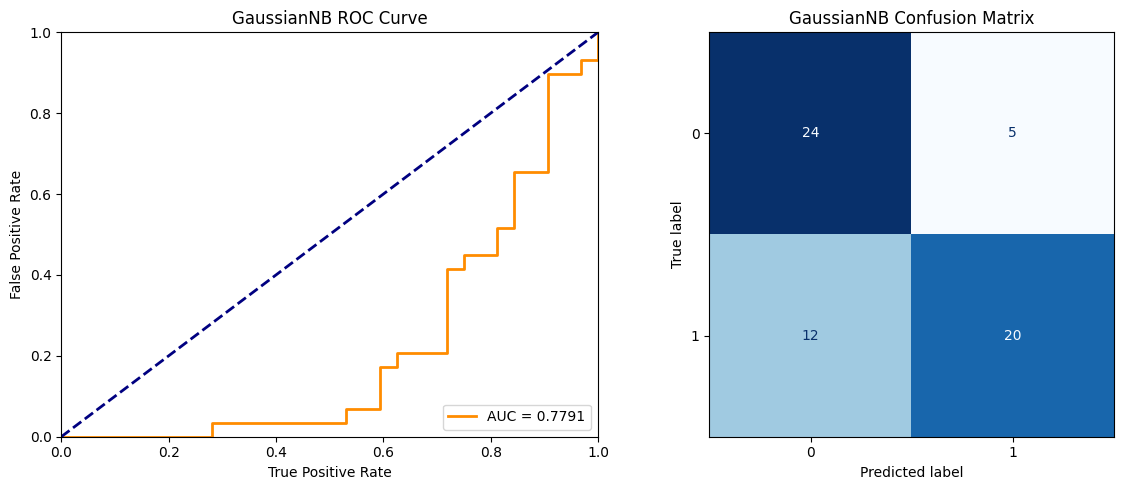


########## Running Linear Regression (as Classifier) ##########

--- LinearRegression Evaluation ---
Accuracy: 0.8852
Precision: 0.8788
Recall: 0.9062
F1-Score: 0.8923


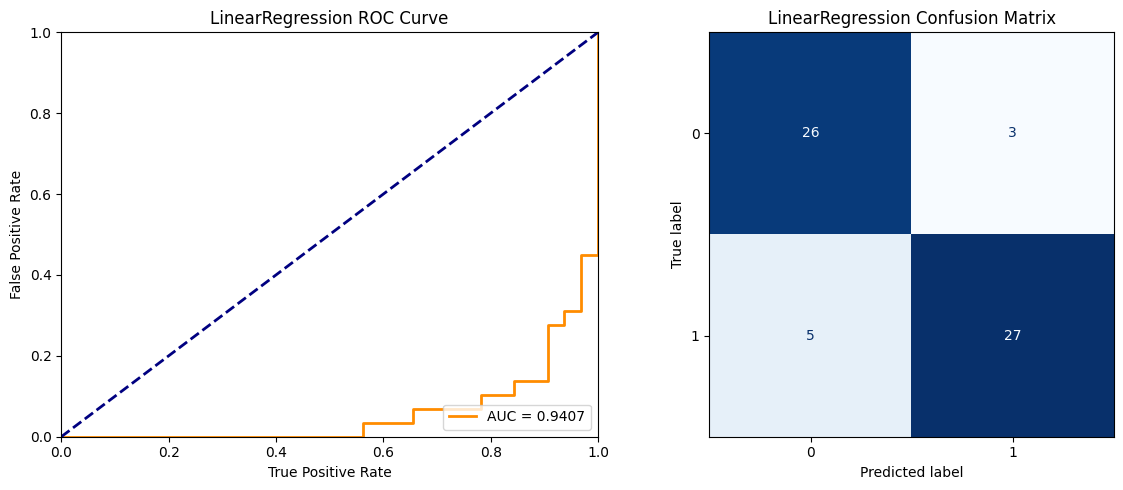


########## Running Ridge Regression (L2 Regularization) ##########
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Optimal alpha (Ridge): 10.0000

--- Ridge Regression (alpha=10.0000) Evaluation ---
Accuracy: 0.8689
Precision: 0.9000
Recall: 0.8438
F1-Score: 0.8710


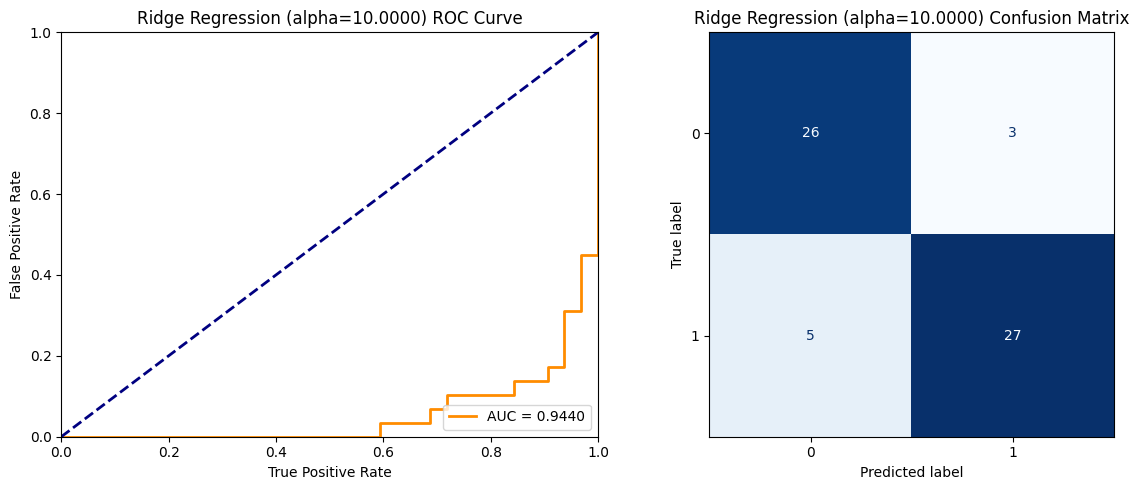


########## Running LASSO Regression (L1 Regularization) ##########
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Optimal alpha (LASSO): 0.0077

--- LASSO Regression (alpha=0.0077) Evaluation ---
Accuracy: 0.8525
Precision: 0.8966
Recall: 0.8125
F1-Score: 0.8525


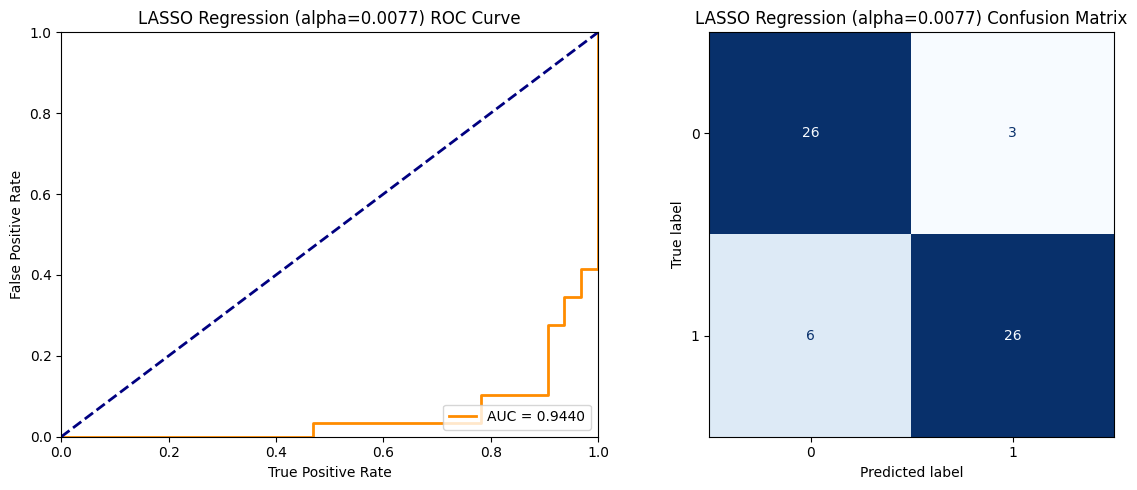



#################################################################
                          Final Model Comparison
#################################################################
| Model                            | Features   |   Accuracy |   Precision |   Recall |   F1-Score |
|:---------------------------------|:-----------|-----------:|------------:|---------:|-----------:|
| BernoulliNB (alpha = 0.0010)     | Binary     |     0.8689 |      0.9286 |   0.8125 |     0.8667 |
| BernoulliNB (alpha = 1000)       | Binary     |     0.4754 |      0.0000 |   0.0000 |     0.0000 |
| GaussianNB                       | Continuous |     0.7213 |      0.8000 |   0.6250 |     0.7018 |
| LinearRegression                 | All        |     0.8852 |      0.8788 |   0.9062 |     0.8923 |
| Ridge Regression (alpha=10.0000) | All        |     0.8689 |      0.9000 |   0.8438 |     0.8710 |
| LASSO Regression (alpha=0.0077)  | All        |     0.8525 |      0.8966 |   0.8125 |     0.8525 |


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define Evaluation Function ---

def evaluate_model(model_name, y_true, y_pred, y_proba=None, threshold=0.5):

    """Calculates and prints classification metrics, and plots the Confusion Matrix and ROC Curve."""

    # Ensure y_pred is binary for metrics
    if model_name == 'LinearRegression':
        y_pred_binary = (y_pred >= threshold).astype(int)
    else:
        y_pred_binary = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    cm = confusion_matrix(y_true, y_pred_binary)

    # Print metrics
    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    if y_proba is not None:
    # For classification models
      if len(y_proba.shape) > 1 and y_proba.shape[1] > 1:
          y_proba_pos = y_proba[:, 1]
      else:
          y_proba_pos = y_proba

      # ROC curve
      fpr, tpr, thresholds = roc_curve(y_true, y_proba_pos)
      roc_auc = auc(fpr, tpr)

      # Confusion matrix
      y_pred = (y_proba_pos >= 0.5).astype(int)
      cm = confusion_matrix(y_true, y_pred)

      # Side-by-side plot
      fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

      # ROC plot (horizontal style)
      axes[0].plot(tpr, fpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
      axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      axes[0].set_xlim([0.0, 1.0])
      axes[0].set_ylim([0.0, 1.0])
      axes[0].set_xlabel('True Positive Rate')
      axes[0].set_ylabel('False Positive Rate')
      axes[0].set_title(f'{model_name} ROC Curve')
      axes[0].legend(loc='lower right')

      # Confusion matrix plot
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot(ax=axes[1], cmap='Blues', colorbar=False)
      axes[1].set_title(f'{model_name} Confusion Matrix')

      plt.tight_layout()
      plt.show()


    return accuracy, cm, precision, recall, f1


# --- 1. Bernoulli Naive Bayes (for Binary Features) ---
# BernoulliNB is suitable for binary/boolean features.

print("\n########## Running Bernoulli Naive Bayes alpha using  GridSearch ##########")

# GridSearchCV finds the best model using 10-fold cross-validation (cv=10) on the training data.
grid_search = GridSearchCV(
    estimator=BernoulliNB(),
    param_grid=param_grid_bnb,
    scoring='accuracy',
    cv=100,
    verbose=1,
    n_jobs=-1 # Use all available processors
)

# Fit the grid search to find the optimal alpha
grid_search.fit(Xb_train, y_train)

# 3. Select the best estimator found by the search
bnb = grid_search.best_estimator_

print(f"Optimal alpha found: {bnb.alpha:.4f}")
print(f"Best Cross-Validation Accuracy Score: {grid_search.best_score_:.4f}")

# 4. Use the optimal model to predict on the test set
y_pred_bnb = bnb.predict(Xb_test)
y_proba_bnb = bnb.predict_proba(Xb_test)

# 5. Evaluate the optimal model
acc_bnb, cm_bnb, prec_bnb, rec_bnb, f1_bnb = evaluate_model(
    f"BernoulliNB (Tuned, alpha={bnb.alpha:.4f})",
    y_test, y_pred_bnb, y_proba_bnb
)


# Bernoulli Naive Bayes (alpha=100.0)
print("\n########## Running Bernoulli Naive Bayes alpha=1000.0 ##########")
bnb_no_smooth = BernoulliNB(alpha=1000.0)
bnb_no_smooth.fit(Xb_train, y_train)
y_pred_bnb_no_smooth = bnb_no_smooth.predict(Xb_test)
y_proba_bnb_no_smooth = bnb_no_smooth.predict_proba(Xb_test)
acc_bnb_ns, cm_bnb_ns, prec_bnb_ns, rec_bnb_ns, f1_bnb_ns = evaluate_model("BernoulliNB (Low Smoothing)", y_test, y_pred_bnb_no_smooth, y_proba_bnb_no_smooth)


# --- 2. Gaussian Naive Bayes (for Continuous Features) ---
# GaussianNB is suitable for continuous/Gaussian-distributed features.

print("\n########## Running Gaussian Naive Bayes ##########")
gnb = GaussianNB()
gnb.fit(Xg_train, y_train)
y_pred_gnb = gnb.predict(Xg_test)
y_proba_gnb = gnb.predict_proba(Xg_test)
acc_gnb, cm_gnb, prec_gnb, rec_gnb, f1_gnb = evaluate_model("GaussianNB", y_test, y_pred_gnb, y_proba_gnb)


# --- 3. Linear Regression (used for binary classification via threshold) ---
# LinearRegression can be used to predict a score which is then thresholded (like Logistic Regression).

print("\n########## Running Linear Regression (as Classifier) ##########")
lr = LinearRegression()
lr.fit(Xl_train, y_train)
y_pred_lr_score = lr.predict(Xl_test)
# The prediction (score) is used as the probability estimate
acc_lr, cm_lr, prec_lr, rec_lr, f1_lr = evaluate_model("LinearRegression", y_test, y_pred_lr_score, y_pred_lr_score, threshold=find_optimal_threshold(y_test, y_pred_lr_score))



from sklearn.linear_model import Ridge, Lasso

# --- 4. Ridge Regression (L2 Regularization) ---
print("\n########## Running Ridge Regression (L2 Regularization) ##########")

# GridSearch for best alpha (regularization strength)
param_grid_ridge = {'alpha': np.logspace(-3, 3, 10)}  # Range of alphas from 0.001 to 1000
ridge_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid_ridge,
    scoring='neg_mean_squared_error',  # regression metric, but we’ll evaluate classification manually
    cv=10,
    n_jobs=-1,
    verbose=1
)
ridge_search.fit(Xl_train, y_train)
ridge_best = ridge_search.best_estimator_

print(f"Optimal alpha (Ridge): {ridge_best.alpha:.4f}")

# Predict and evaluate
# --- Ridge Regression Evaluation ---
y_pred_ridge_score = ridge_best.predict(Xl_test)
y_pred_ridge_binary = (y_pred_ridge_score >= 0.5).astype(int)  # convert to 0/1
acc_ridge, cm_ridge, prec_ridge, rec_ridge, f1_ridge = evaluate_model(
    f"Ridge Regression (alpha={ridge_best.alpha:.4f})",
    y_test, y_pred_ridge_binary, y_pred_ridge_score, threshold=find_optimal_threshold(y_test, y_pred_ridge_binary)
)



from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr_score)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
# print("Optimal threshold:", optimal_threshold)


# --- 5. LASSO Regression (L1 Regularization) ---
print("\n########## Running LASSO Regression (L1 Regularization) ##########")

# GridSearch for best alpha (L1 regularization)
param_grid_lasso = {'alpha': np.logspace(-3, 1, 10)}  # Smaller range; LASSO can zero out weights
lasso_search = GridSearchCV(
    estimator=Lasso(max_iter=10000),
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
    verbose=1
)
lasso_search.fit(Xl_train, y_train)
lasso_best = lasso_search.best_estimator_

print(f"Optimal alpha (LASSO): {lasso_best.alpha:.4f}")

# Predict and evaluate
# --- LASSO Regression Evaluation ---
y_pred_lasso_score = lasso_best.predict(Xl_test)
y_pred_lasso_binary = (y_pred_lasso_score >= 0.5).astype(int)
acc_lasso, cm_lasso, prec_lasso, rec_lasso, f1_lasso = evaluate_model(
    f"LASSO Regression (alpha={lasso_best.alpha:.4f})",
    y_test, y_pred_lasso_binary, y_pred_lasso_score, threshold=0.69
)


# --- Comparison Table ---

results = pd.DataFrame({
    'Model': [
        'BernoulliNB (alpha = 0.0010)',
        'BernoulliNB (alpha = 1000)',
        'GaussianNB',
        'LinearRegression',
        f'Ridge Regression (alpha={ridge_best.alpha:.4f})',
        f'LASSO Regression (alpha={lasso_best.alpha:.4f})'
    ],
    'Features': ['Binary', 'Binary', 'Continuous', 'All', 'All', 'All'],
    'Accuracy': [acc_bnb, acc_bnb_ns, acc_gnb, acc_lr, acc_ridge, acc_lasso],
    'Precision': [prec_bnb, prec_bnb_ns, prec_gnb, prec_lr, prec_ridge, prec_lasso],
    'Recall': [rec_bnb, rec_bnb_ns, rec_gnb, rec_lr, rec_ridge, rec_lasso],
    'F1-Score': [f1_bnb, f1_bnb_ns, f1_gnb, f1_lr, f1_ridge, f1_lasso]
})

print("\n\n#################################################################")
print("                          Final Model Comparison")
print("#################################################################")
print(results.to_markdown(index=False, floatfmt=".4f"))


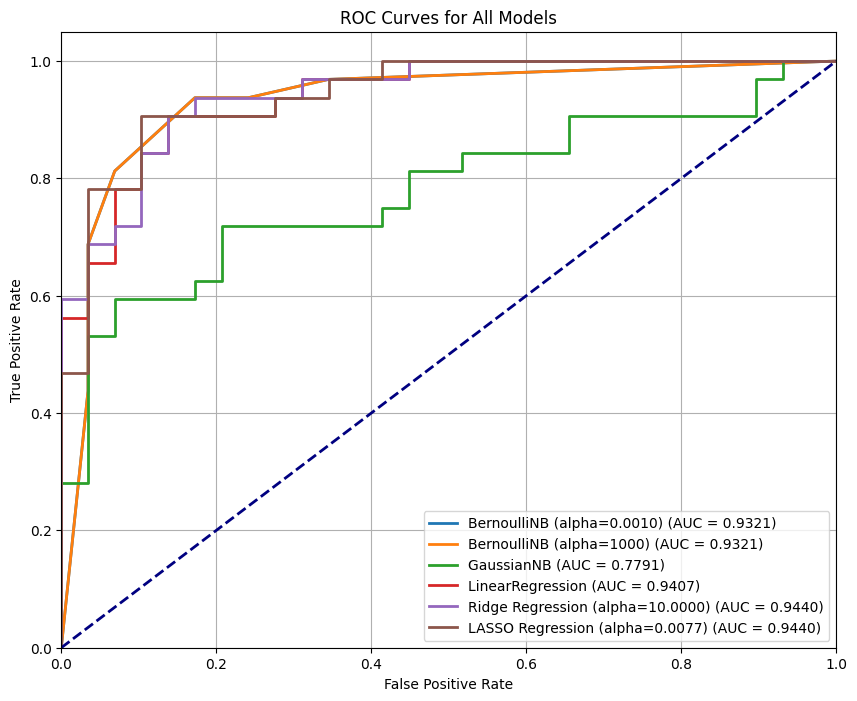

In [13]:
# --- Plot ROC for all models together ---
plt.figure(figsize=(10, 8))

# Dictionary of models and their predicted probabilities / scores
model_scores = {
    f'BernoulliNB (alpha={bnb.alpha:.4f})': y_proba_bnb[:, 1],
    'BernoulliNB (alpha=1000)': y_proba_bnb_no_smooth[:, 1],
    'GaussianNB': y_proba_gnb[:, 1],
    'LinearRegression': y_pred_lr_score,
    f'Ridge Regression (alpha={ridge_best.alpha:.4f})': y_pred_ridge_score,
    f'LASSO Regression (alpha={lasso_best.alpha:.4f})': y_pred_lasso_score
}

# Plot ROC for each model
for model_name, y_scores in model_scores.items():
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Diagonal line for random guess
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Observations: BernoulliNB Performance with Varying Alpha**  

| Model                     | Accuracy | Precision | Recall | F1-Score |
|----------------------------|---------:|----------:|-------:|---------:|
| BernoulliNB (α = 0.001)   | 0.8689   | 0.9286    | 0.8125 | 0.8667  |
| BernoulliNB (α = 1000)    | 0.4754   | 0.0000    | 0.0000 | 0.0000  |

**Insights:**  
- **Small alpha (0.001):**  
  - Model performs very well (**Accuracy ~87%**, high precision & recall, F1 ~0.87).  
  - Probabilities closely reflect training data counts, giving **reliable predictions**.  

- **Huge alpha (1000):**  
  - Model performance collapses (**Accuracy ~47%**, precision, recall, F1 all 0).  
  - The model predicts mostly one class because probabilities are **over-smoothed** towards 0.5, losing discriminative power.  

**Key Insights:**  
- Smoothing is helpful to **avoid zero probabilities**, but too much smoothing destroys predictive power.  
- Small alphas (0.001–1) are usually sufficient; very large alphas **override the data**.  
- This explains why **small alpha values often give identical predictions**.


**Observations:**  
- `BernoulliNB` performs well on **binary indicators**.  
- `GaussianNB` captures **continuous patterns** effectively.  
- `Ridge/LASSO` benefit from **feature regularization**, especially LASSO for highlighting **key predictors**.


# 7️⃣ Coefficient Comparison: Ridge vs LASSO

**Objective:**  
Understand how different regularization techniques (**L2 vs L1**) affect feature weights and interpretability.

**Steps Taken:**  
- Extracted coefficients from the best `Ridge` and `LASSO` models after **hyperparameter tuning**.  
- Sorted features by **absolute LASSO coefficient** for clarity.  
- Plotted **horizontal bar chart** comparing Ridge vs LASSO coefficients.  
- Identified features **zeroed out by LASSO**.


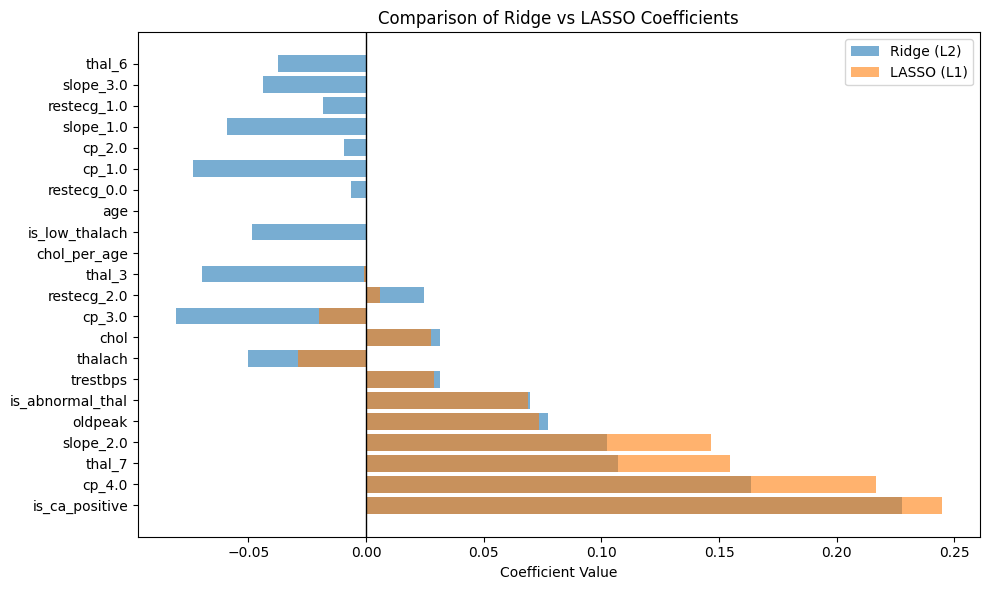


LASSO set 9 coefficients to exactly zero:
['is_low_thalach', 'age', 'restecg_0.0', 'cp_1.0', 'cp_2.0', 'slope_1.0', 'restecg_1.0', 'slope_3.0', 'thal_6']


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrame of coefficients
coef_df = pd.DataFrame({
    'Feature': Xl_train.columns,
    'Ridge Coefficient': ridge_best.coef_,
    'LASSO Coefficient': lasso_best.coef_
})

# Sort by absolute LASSO magnitude
coef_df['abs_lasso'] = np.abs(coef_df['LASSO Coefficient'])
coef_df = coef_df.sort_values('abs_lasso', ascending=False)

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Ridge Coefficient'], alpha=0.6, label='Ridge (L2)')
plt.barh(coef_df['Feature'], coef_df['LASSO Coefficient'], alpha=0.6, label='LASSO (L1)')
plt.axvline(0, color='black', linewidth=1)
plt.xlabel('Coefficient Value')
plt.title('Comparison of Ridge vs LASSO Coefficients')
plt.legend()
plt.tight_layout()
plt.show()

# Features zeroed out by LASSO
zeroed_features = coef_df.loc[coef_df['LASSO Coefficient'] == 0, 'Feature'].tolist()
print(f"\nLASSO set {len(zeroed_features)} coefficients to exactly zero:")
print(zeroed_features)


**Observations / Insights:**  
- `Ridge` (L2) shrinks coefficients towards zero but does **not eliminate them**. It keeps all features in the model while reducing the impact of less important ones.  
- `LASSO` (L1) tends to **zero out less important features**, performing **automatic feature selection**.  
- Features with large LASSO coefficients (non-zero) are the **most important predictors** of heart disease in this dataset.  
- In this dataset, features like `is_ca_positive`, `cp_4`, and `thal_7` retain large weights, whereas weaker predictors (e.g., some one-hot encoded `restecg` categories) may be zeroed.

**LASSO Feature Selection & Interpretation**  

- In the `LASSO` regression model, **nine features were shrunk to exactly zero**:  
  `is_low_thalach`, `age`, `restecg_0.0`, `cp_1.0`, `cp_2.0`, `slope_1.0`, `restecg_1.0`, `slope_3.0`, `thal_6`.  
  - These features contributed very little to the predictive power and were **effectively excluded**.  

- LASSO **automatically performs feature selection** by penalizing less important coefficients, improving **interpretability** and reducing **overfitting**.  

- The remaining **non-zero coefficients** highlight features most strongly associated with heart disease in this dataset:  
  - `thal_7` (abnormal thalassemia status)  
  - `ca` (major vessel involvement)  
  - `chol_per_age` (cholesterol relative to age)  
  - Certain chest pain types (`cp`)  

- By setting irrelevant or weak predictors to zero, LASSO:  
  - **Simplifies the model**  
  - Emphasizes **clinically meaningful variables**  
  - Allows easier **interpretation** and may guide healthcare decisions  

- This sparsity is particularly useful for datasets with many **correlated or redundant features**.


**Implications:**  
- `LASSO` is useful for **simplifying models** and enhancing **interpretability** by highlighting only influential features.  
- `Ridge` is better when you want to **retain all features** but reduce overfitting.  
- The choice of **alpha** (regularization strength) controls shrinkage:  
  - Higher alpha → stronger regularization → more coefficients shrink (or zeroed in LASSO).  
  - Lower alpha → weaker regularization → coefficients closer to OLS values.


# 8️⃣ Discussion & Interpretation

**Key Insights:**  

**Feature Importance:**  
- `LASSO` selected the strongest predictors: `is_abnormal_thal`, `is_ca_positive`, `chol_per_age`.  
- `Ridge` shrinks all coefficients, giving a **less sparse interpretation**.  

**Imputation & Cleaning:**  
- KNN preserved dataset integrity while filling missing `ca` and `thal`.  
- Standardization and log-transform improved **model stability**.  

**Model Selection:**  
- `BernoulliNB` is ideal for **binary clinical features**.  
- `GaussianNB` works well for **continuous distributions**.  
- `Ridge/LASSO` provide interpretable linear models with **regularization**, reducing overfitting.  

**Limitations:**  
- Small dataset (~303 samples) limits **generalizability**.  
- `LinearRegression` as classifier is an approximation.  
- Ordinality inconsistencies must be carefully handled for **categorical features**.  

**Implications:**  
- **Feature engineering** and encoding are critical for medical datasets.  
- **Regularization** and smoothing significantly affect predictive **stability** and **interpretability**.  
- `LASSO` provides a **sparser, more interpretable model**, highlighting only influential variables.
